In [1]:
#
# Jung_Hyeuk_Project3.py
# MGMTMFE405-2 Computational Methods in Finance - Project 3
# Hyeuk Jung (005250560)
#

import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import *

np.random.seed(int(time.time()))

def plots(title, legend, x, y, z):
    plt.plot(x, y)
    plt.plot(x, z)
    plt.title(title)
    plt.gca().legend(legend)
    plt.show()

# Value process with one brownian motion
def process(func, Y0, t = 2, n = 2000, npath = 500):
    Y = list()
    Y_paths = pd.DataFrame()
    dt = t/n; sqrtdt = sqrt(dt)
    for i in range(npath):
        Y.clear()
        Y.append(Y0)
        Z = np.random.normal(0, 1, n)
        W = [sqrtdt*z for z in Z]
        time = np.arange(dt, t+dt, dt)
        temp = [ Y.append(func(Y[-1], tt, dt, w)) for tt, w in zip(time, W) ]
        column = 'path' + str(i)
        Y_paths[column] = Y
    return Y_paths

# Value process with two independent brownian processes
def process2(func, Y0, t = 2, n = 2000, npath = 500):
    Y = list()
    Y_paths = pd.DataFrame()
    dt = t/n; sqrtdt = sqrt(dt)
    for i in range(npath):
        Y.clear()
        Y.append(Y0)
        Z1 = np.random.normal(0, 1, n)
        Z2 = np.random.normal(0, 1, n)
        W1 = [sqrtdt*z for z in Z1]
        W2 = [sqrtdt*z for z in Z2]
        time = np.arange(dt, t+dt, dt)
        temp = [ Y.append(func(Y[-1], tt, dt, w, z)) for tt, w, z in zip(time, W1, W2) ]
        column = 'path' + str(i)
        Y_paths[column] = Y
    return Y_paths



In [2]:
##### 1. 
# X2 process #X0 = 1; Y0 = 3/4; #dt = 2/2000; sqrtdt = sqrt(dt)
f = lambda Yt, tt, dt, w: Yt + (0.2 - 0.5*Yt)*dt + 2/3*w
X2_paths = process(func=f, Y0 = 1, t = 2)
# Y2 process
f = lambda Yt, tt, dt, w: Yt + ( (2/(1+tt))*Yt + (1+tt**3)/3 )*dt + (1+tt**3)/3*w
Y2_paths = process(func = f, Y0=3/4, t = 2)
# Y3 process; dt = 3/3000
Y3_paths = process(func = f, Y0=3/4, t = 3, n=3000)

# 1) P(Y2 > 5) result: Prob
prob = sum(1 if y > 5 else 0 for y in Y2_paths.iloc[-1]) / len(Y2_paths.iloc[-1])
print("Prob:", prob)
# 2) E(X2^(1/3)) result: E1
E1 = np.mean([ x**(1/3) if x >= 0 else -(-x)**(1/3) for x in X2_paths.iloc[-1] ])
print("E1:", E1)
# 3) E(Y3) result: E2
E2 = float(np.mean(Y3_paths.iloc[-1])) # to remove the array notation when printing the result
print("E2:", E2)
# 4) E(X2*Y2 | X2 > 1) result: E3
E3 = np.mean([ x*y if x > 1 else 0 for x, y in zip(X2_paths.iloc[-1], Y2_paths.iloc[-1]) ])
print("E3:", E3)



Prob: 0.974
E1: 0.657152922361613
E2: 25.569386769881515
E3: 4.430579764666179


In [3]:
##### 2. 
# 1) X3 process
f = lambda Yt, tt, dt, w, z: Yt + 0.25*Yt*dt + 1/3*Yt*w - 3/4*Yt*z
X3_paths = process2(func=f, Y0=1, t=3, n=3000)
E1 = np.mean([ (1 + x)**(1/3) for x in X3_paths.iloc[-1] ])
print("E1:", E1)
# 2) Y3 process
f = lambda Yt, tt, dt, w, z: exp(-0.08*tt + 1/3*w + 3/4*z)
#The weiner process at time 0 is 0 by definition -> Y0 = exp(0) = 1
Y3_paths = process2(func=f, Y0=1, t=3, n=3000)
E2 = np.mean([ (1 + y)**(1/3) for y in Y3_paths.iloc[-1] ])
print("E2:", E2)



E1: 1.3036989401704244
E2: 1.2136632257117614


C1 (Monte Carlo simulation): [0.0, 0.0, 0.0, 0.0, 0.0, 0.08606557024832431, 1.070484361952084, 2.0549817241348847, 3.039480355306177, 4.023978005485478, 5.008476228187773]
C2 (Black Scholes): [0.08575224964083072, 0.19426379388619708, 0.38281594216343207, 0.6732188321361763, 1.0786818258914028, 1.6016002500234343, 2.234509540069764, 2.9630346364161486, 3.7695364024664073, 4.636186824816331, 5.547057548146441]


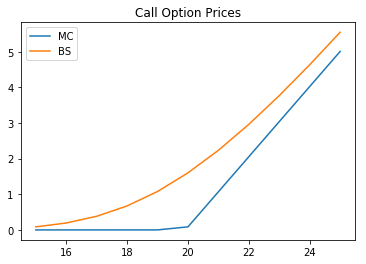

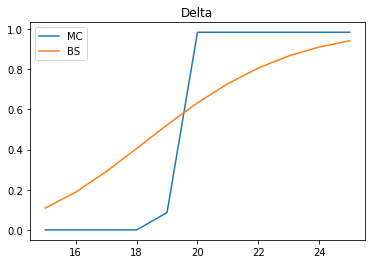

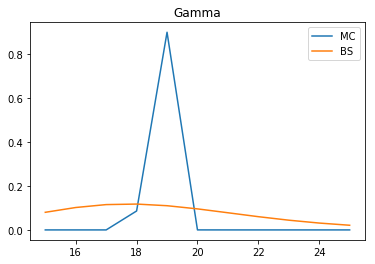

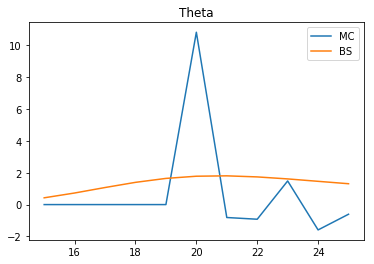

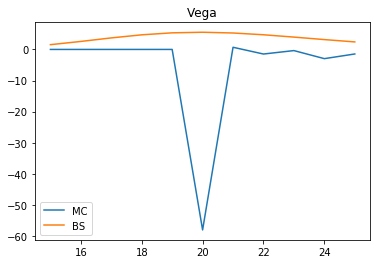

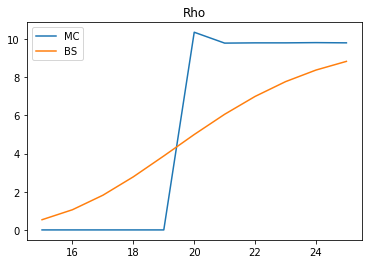

In [4]:
##### 3. 
# Monte Carlo
def montecarlo(S0, T, X, r, sd):
    # Generate 10,000 S_Ts
    # Using Antithetic Variates method
    dt = T/10000; sqrtdt = sqrt(dt); discount = exp(-1*r*T)
    z = np.random.normal(0, 1, 10000)
    
    W = [sqrtdt*x for x in z]
    W_anti = [sqrtdt*(-1)*x for x in z]
    
    S = [ S0*exp(sd*w + (r-sd*sd/2)*T) for w in W]
    S_anti = [ S0*exp(sd*w_anti + (r-sd*sd/2)*T) for w_anti in W_anti]
    
    c = [ discount*(max(0, (s - X))) for s in S ]
    c_anti = [ discount*(max(0, (s_anti - X))) for s_anti in S_anti ]

    C = np.mean([ (x + y)/2 for x, y in zip(c, c_anti) ])
    return C

# Black-Scholes
def N(x):
    if x >= 0:
        return(1 - 0.5*(1 + 0.0498673470*x + 0.0211410061*x*x 
                        + 0.0032776263*(x**3) + 0.0000380036*(x**4) 
                        + 0.0000488906*(x**5) + 0.0000053830*(x**6))**(-16))
    else:
        y = -1*x
        return(1- N(y))

def bs_call(S0, T, X, r, sd):
    sqrtT = sqrt(T)
    d1 = 1/sd/sqrtT * ( log(S0/X) + (r + sd*sd/2)*T )  #(log(S0/X) + (r + sd*sd/2)*T) / (sd*sqrtT)
    d2 = d1 - sd*sqrtT
    N_d1 = N(d1)
    N_d2 = N(d2)
    C = S0*N_d1 - X*exp(-1*r*T)*N_d2
    return C #bs
    
def delta(func, s, T, X, r, sd, dS):
    return (func(s+dS, T, X, r, sd) - func(s, T, X, r, sd))/dS

# Hedging parameters 
S0 = range(15, 26, 1); T = 0.5; X = 20; r = 0.04; sd = 0.25

monte = [montecarlo(s, T, X, r, sd) for s in S0]
print('C1 (Monte Carlo simulation):', monte)
bs = [bs_call(s, T, X, r, sd) for s in S0]
print('C2 (Black Scholes):', bs)
plots("Call Option Prices", ('MC', 'BS'), S0, monte, bs)

# Delta
dS = 1
monte_delta = [ (montecarlo(s+dS, T, X, r, sd) - montecarlo(s, T, X, r, sd))/dS for s in S0 ]
bs_delta = [ (bs_call(s+dS, T, X, r, sd) - bs_call(s, T, X, r, sd))/dS for s in S0 ]
plots("Delta", ('MC', 'BS'), S0, monte_delta, bs_delta) #bs_deltatest['delta']
# Gamma
monte_gamma = [ (delta(montecarlo, s+1, T, X, r, sd, dS) - delta(montecarlo, s, T, X, r, sd, dS))/dS for s in S0 ]
bs_gamma = [ (delta(bs_call, s+1, T, X, r, sd, dS) - delta(bs_call, s, T, X, r, sd, dS))/dS for s in S0 ]
plots("Gamma", ('MC', 'BS'), S0, monte_gamma, bs_gamma)
# Theta
dT = 0.0000005
monte_theta = [ (montecarlo(s, T, X, r, sd) - montecarlo(s, T-dT, X, r, sd))/dT for s in S0 ]
bs_theta = [ (bs_call(s, T, X, r, sd) - bs_call(s, T-dT, X, r, sd))/dT for s in S0 ]
plots("Theta", ('MC', 'BS'), S0, monte_theta, bs_theta)
# Vega
dSD = 0.0000005
monte_vega = [ (montecarlo(s, T, X, r, sd+dSD) - montecarlo(s, T, X, r, sd))/dSD for s in S0 ]
bs_vega = [ (bs_call(s, T, X, r, sd+dSD) - bs_call(s, T, X, r, sd))/dSD for s in S0 ]
plots("Vega", ('MC', 'BS'), S0, monte_vega, bs_vega)
# Rho
dRHO = 0.00004
monte_rho = [ (montecarlo(s, T, X, r+dRHO, sd) - montecarlo(s, T, X, r, sd))/dRHO for s in S0 ]
bs_rho = [ (bs_call(s, T, X, r+dRHO, sd) - bs_call(s, T, X, r, sd))/dRHO for s in S0 ]
plots("Rho", ('MC', 'BS'), S0, monte_rho, bs_rho)


In [5]:
##### 4. 
def Heston(method, S0, V0, rho, r, a, b, sd, t = 2, n = 2000, npath = 1000):
    # S_t+1 = St + r*St*dt + sqrt(Vt)*St*sqrtdt*Z1
    # V_t+1 = Vt + a*(b - Vt)*dt + sd*sqrt(Vt)*sqrtdt*(Z2 = rho*Z1 + sqrt(1-rho^2)*Z2)
    S = list()
    V = list()
    S_paths = pd.DataFrame()
    V_paths = pd.DataFrame()
    dt = t/n; sqrtdt = sqrt(dt)
    for i in range(npath):
        S.clear()
        V.clear()
        S.append(S0)
        V.append(V0)
        Z1 = np.random.normal(0, 1, n)
        Z2 = np.random.normal(0, 1, n)
        W1 = [ sqrtdt*z for z in Z1 ]
        W2 = [ sqrtdt*(rho*z1 + sqrt(1-rho*rho)*z2) for z1, z2 in zip(Z1,Z2) ]
        if method == "reflection":
            v_temp = [ V.append( abs(V[-1]) + a*(b - abs(V[-1]))*dt + sd*sqrt(abs(V[-1]))*w2 ) for w2 in W2 ]
        elif method == "partial":
            v_temp = [ V.append( V[-1] + a*(b - V[-1])*dt + sd*sqrt(max(0, V[-1]))*w2 ) for w2 in W2 ]
        else: # full
            v_temp = [ V.append( V[-1] + a*(b - max(0, V[-1]))*dt + sd*sqrt(max(0, V[-1]))*w2 ) for w2 in W2 ]

        s_temp = [ S.append( S[-1] + r*S[-1]*dt + sqrt(V[i])*S[-1]*w1 ) for i, w1 in zip(range(len(V)), W1) ]
        column = 'path' + str(i)
        S_paths[column] = S
        V_paths[column] = V
    return S_paths, V_paths

K = 50; T = 0.5; rho = -0.6; r = 0.03; S0 = 48; V0 = 0.05; sd = 0.42; a = 5.8; b = 0.0625
n = 1000; dt = T/n; discount = exp(-1*r*T)
# 1) Full Truncation
S1, V1 = Heston("Full", S0, V0, rho, r, a, b, sd, t = T, n = n)
full_S = S1.iloc[-1] # get S_T
C1 = np.mean([ discount*(max(0, (s - K))) for s in full_S ])
print("C1 (Full Truncation):", C1)
# 2) Partial Truncation
S2, V2 = Heston("partial", S0, V0, rho, r, a, b, sd, t = T, n = n)
partial_S = S2.iloc[-1] # get S_T
C2 = np.mean([ discount*(max(0, (s - K))) for s in partial_S ])
print("C2 (Partial Truncation):", C2)
# 3) Reflection method
S3, V3 = Heston("reflection", S0, V0, rho, r, a, b, sd, t = T, n = n)
reflection_S = S3.iloc[-1] # get S_T
C3 = np.mean([ discount*(max(0, (s - K))) for s in reflection_S ])
print("C3 (Reflection Method):", C3)


C1 (Full Truncation): 2.8310971306909147
C2 (Partial Truncation): 2.582572483171839
C3 (Reflection Method): 2.563188972305308


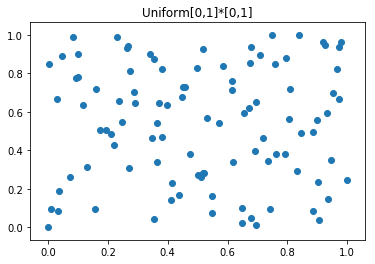

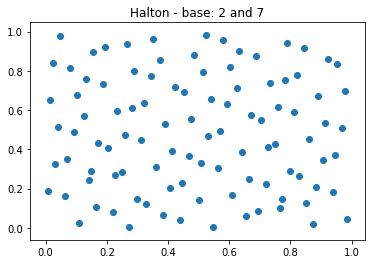

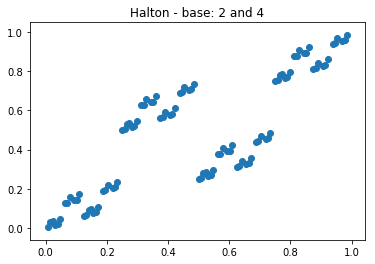

5.d):
First, plots from uniform distribution and Halton sequences with base of 2 and 7 seems to be uniformly in the area.
Compared to other two plots, the points using base 2 and 4 shows strong correlations.
Due to linear relationship between two bases, the 2-dimensional sequences are not scattered in the area but clustered.
5.e) Halton - base 2 and 4: -0.00488389829700337
5.e) Halton - base 2 and 7: 0.02611439677274074
5.e) Halton - base 5 and 7: 0.026163659530512064


In [6]:
##### 5. 
def randomlgm(X0, n):
    # LGM Method parameters
    m = 2**31 - 1; a = 7**5; b = 0
    # Generate n random variables
    X = list()
    X.append(X0)
    for i in range(n-1):
        X.append( (a*X[i] + b) % m ) #x1 = (a*X[i] + b) % m
    # Transform random numbers to follow U[0,1]
    uniform = list(map(lambda x: x/m, X))
    return uniform

def Halton(k, m):
    # k: k-th number in the sequance with base m
    # m: base    
    temp = list()
    while k:
        k, a = divmod(k, m)
        temp.append(a)
    h = np.sum([a / m**i for a, i in zip(temp, range(1, len(temp)+1, 1))])
    return h

# formula given in Q5. e)
def f(x, y):
    term_1 = exp(-1*x*y)
    term_2 = sin(6*pi*x)
    temp = cos(2*pi*y)
    if temp >= 0:
        term_3 = temp**(1/3)
    else: # temp < 0
        term_3 = -(-temp)**(1/3)
    return term_1 * (term_2 + term_3)

# a) Uniform[0,1]*[0,1]
uniform = [randomlgm(1345, 100), randomlgm(12346, 100)]
plt.scatter(uniform[0], uniform[1])
plt.title('Uniform[0,1]*[0,1]')
plt.savefig('5_d_uniform.png')
plt.show()

# b) Halton() - base: 2, 7
x = [ Halton(i, 2) for i in range(1, 101, 1)]
y = [ Halton(i, 7) for i in range(1, 101, 1)]
plt.scatter(x, y)
plt.title('Halton - base: 2 and 7')
plt.savefig('5_d_halton_base27.png')
plt.show()

# c) Halton() - base: 2, 4
xx = [ Halton(i, 2) for i in range(1, 101, 1)]
yy = [ Halton(i, 4) for i in range(1, 101, 1)]
plt.scatter(xx, yy)
plt.title('Halton - base: 2 and 4')
plt.savefig('5_d_halton_base24.png')
plt.show()

# d) Plots and comment
print('5.d):\nFirst, plots from uniform distribution and Halton sequences with base of 2 and 7 seems to be uniformly in the area.\nCompared to other two plots, the points using base 2 and 4 shows strong correlations.\nDue to linear relationship between two bases, the 2-dimensional sequences are not scattered in the area but clustered.')
# e) Integral with different Halton results
n = 10000
x_1 = [ Halton(i, 2) for i in range(1, n+1, 1)]
y_1 = [ Halton(i, 4) for i in range(1, n+1, 1)]
e_1 = np.mean( [f(x, y) for x, y in zip(x_1, y_1)] )
print('5.e) Halton - base 2 and 4:', e_1)
x_2 = [ Halton(i, 2) for i in range(1, n+1, 1)]
y_2 = [ Halton(i, 7) for i in range(1, n+1, 1)]
e_2 = np.mean( [f(x, y) for x, y in zip(x_2, y_2)] )
print('5.e) Halton - base 2 and 7:', e_2)
x_3 = [ Halton(i, 5) for i in range(1, n+1, 1)]
y_3 = [ Halton(i, 7) for i in range(1, n+1, 1)]
e_3 = np.mean( [f(x, y) for x, y in zip(x_3, y_3)] )
print('5.e) Halton - base 5 and 7:', e_3)
